# Путешествие по Спрингфилду.

 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

In [ ]:
!pip3 install wheel==0.34.1

In [ ]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl


In [ ]:
import torch
import torchvision
import numpy as np
from torch import nn, optim
train_on_gpu = torch.cuda.is_available()
from torchvision import datasets, models, transforms
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached Pillow-5.3.0-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


5.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Dec  6 14:23:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:

DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224

DEVICE = torch.device("cuda")

Ниже я использую специальный класс для подготовки данных к обучаемому виду.

Я делаю label encoding над всеми классами (симпсонами) обучаеющего и валидационного датасетов.

В методе __getitem__ я произвожу различные преобразования над данными (аугментация, преобразование в тензор, нормировка), чтобы увеличить обучаемую выборку и сделать все картинки одинакового размера.

In [ ]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()

        self.files = sorted(files)

        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = {
            'val': transforms.Compose([
                transforms.Resize(RESCALE_SIZE),
                transforms.CenterCrop(RESCALE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'train': transforms.Compose([
                transforms.Resize(256),
                transforms.RandomResizedCrop(RESCALE_SIZE),
                transforms.ColorJitter(hue=.05, saturation=.05),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(20),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])}
        x = self.load_sample(self.files[index])
        if self.mode == 'test':
            x = transform['val'](x)
            return x
        else:
            label = self.labels[index]
            x=transform[self.mode](x)
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

Функция для отрисовки картинок в формате тензоров

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Достаем данные

In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Разделяем данные на выборки

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета

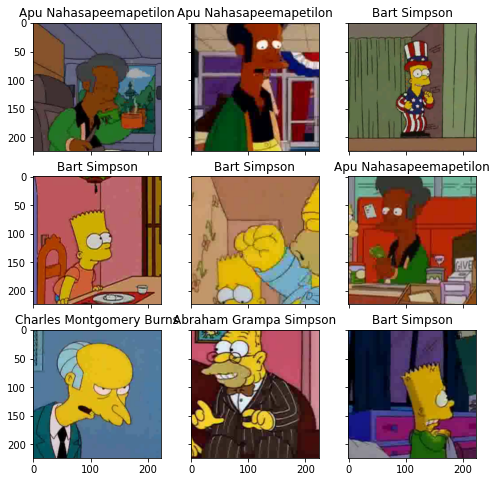

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Обучение одной эпохи

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

Валидация на одной эпохе

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Сам код обучения модели. Я пробовал различные оптимизаторы и критерии, с различными параметрами внутри них (убил на это около 20 часов обучения), но в результате адам и кросс-энтропия оказались лучшим сочетанием

In [ ]:
def train(train_files, val_files, model, opt, criterion, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    best_model = model.state_dict()
    best_acc = 0.0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_model = model.state_dict()

            #scheduler.step()
    model.load_state_dict(best_model)        
    return history

Функция предсказания для лоадера

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Я использовал модель efficientnet b6. К ней я пришел после двух других моделей (ResNet и Inception v3). Разумеется, я не обучал их с нуля (хотя попытался, но колаб быстро сказал мне, что его память кончилась). Я использовал fine-tuning и заменил последний слой классификатора на тот, который нам нужен. Дропаут был в модели изначально и я не стал его исключать.

In [ ]:
n_classes = len(np.unique(train_val_labels))
my_model = models.efficientnet_b6(pretrained=True, progress=True)
my_model.classifier=nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=2304, out_features=n_classes, bias=True)
  )

В модели было всего 7 слоев и я решил заморозить первые 4 слоя и обучать модель на последних трех. Я пробовал замораживать 5 слоев, но модель выдавала ощутимо хуже результаты. Про время обучения - да, было достаточно долго (порядка 1.5 часа каждая модель), но благо я делал все не в последний день и мог оставить модель обучаться и пойти гулять.

In [ ]:
layers_to_unfreeze = 3
for param in my_model.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

Да, я также пробовал использовать scheduler для learning rate, но почему-то моя модель ломалась.. Я решил, что и без этого у меня вполне хорошие результаты, поэтому перестал пробовать. Но все же мне интересно как правильно надо было его использовать, поэтому посмотрю в работах других ребят.

In [ ]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()(torch.log(y_pred), y_true) 
#optimizer = optim.AdamW(my_model.parameters(), lr=0.05, betas=(0.9, 0.999), weight_decay=0.01)
optimizer=torch.optim.Adam(my_model.parameters())
#scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=2, gamma=0.5)

Смотрел на количество классов модели и на саму модель.

P.S. можете расскомментить последнюю строчку и сами посмотреть на полную модель. Она прекрасна!

In [ ]:
my_model.to(DEVICE)
my_model.aux_logits = False
print("we will classify :{}".format(n_classes))
#print(my_model)

we will classify :42


Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, my_model, optimizer, criterion, epochs=5, batch_size=32)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.3359442789415332


epoch:  20%|██        | 1/5 [13:47<55:11, 827.82s/it]


Epoch 001 train_loss: 1.3359     val_loss 0.2590 train_acc 0.6577 val_acc 0.9274
loss 0.9203872482456503


epoch:  40%|████      | 2/5 [27:29<41:12, 824.05s/it]


Epoch 002 train_loss: 0.9204     val_loss 0.2683 train_acc 0.7617 val_acc 0.9301
loss 0.7570205115992534


epoch:  60%|██████    | 3/5 [41:13<27:28, 824.03s/it]


Epoch 003 train_loss: 0.7570     val_loss 0.2362 train_acc 0.7981 val_acc 0.9398
loss 0.7208537947858957


epoch:  80%|████████  | 4/5 [55:04<13:46, 826.92s/it]


Epoch 004 train_loss: 0.7209     val_loss 0.2227 train_acc 0.8127 val_acc 0.9427
loss 0.6849037682951632


epoch: 100%|██████████| 5/5 [1:08:53<00:00, 826.63s/it]



Epoch 005 train_loss: 0.6849     val_loss 0.1858 train_acc 0.8187 val_acc 0.9541


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

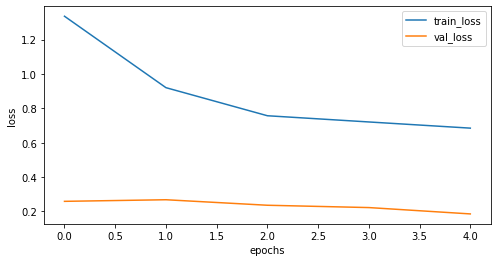

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

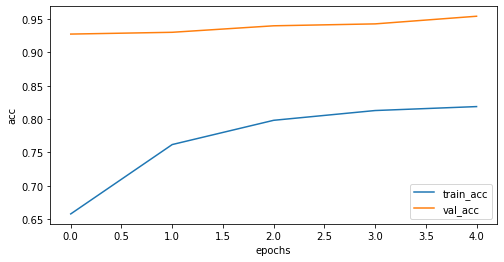

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Нет, это не ошибка, что валидационная accuracy выше обучаемой. Все дело как раз в аугментации, которая сильнее карает нашу модель на стадии обучения, зато на валидационные данные она приходит избитая, но подготовленная. 

### Сабмит. Ничего интересного.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратим внимание, что метрика, которую необходимо оптимизировать в конкурсе -- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
print(actual_labels)
print(preds_class)
print(y_pred)

[0, 4, 0, 4, 4, 0, 4, 6, 0, 2, 2, 4, 4, 2, 4, 0, 4, 0, 5, 6]
['abraham_grampa_simpson', 'bart_simpson', 'abraham_grampa_simpson', 'bart_simpson', 'milhouse_van_houten', 'abraham_grampa_simpson', 'bart_simpson', 'charles_montgomery_burns', 'abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'apu_nahasapeemapetilon', 'bart_simpson', 'bart_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'milhouse_van_houten', 'bart_simpson', 'abraham_grampa_simpson', 'carl_carlson', 'charles_montgomery_burns']
[ 0  4  0  4 25  0  4  6  0  2  2  4  4  2  4 25  4  0  5  6]


In [ ]:
from sklearn.metrics import f1_score

f1_score(np.array(actual_labels), y_pred, average="weighted")


0.946060606060606

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

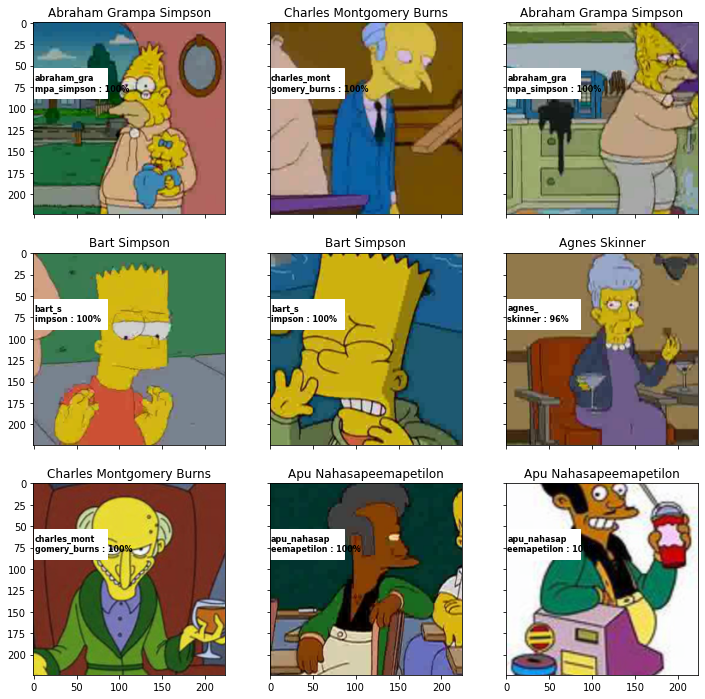

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    prob_pred = predict_one_sample(my_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left',
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/Colab Notebooks/simpsons/Simpsons_result.csv', index=False)

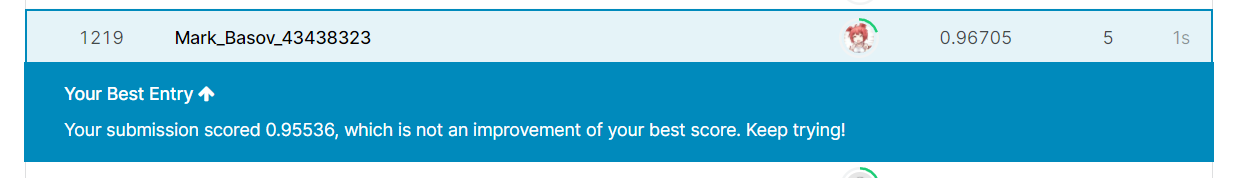